In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")

    
# To REMOOOOOOOOOOOOOOOOOOOOOOOOVE 
#DEVICE = torch.device("cpu")

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
    
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [2]:
import torch.nn.functional as F

class ReflexiveModel(nn.Module):
    """This is the class to build a custom feed
    forward reflexive network that is easily built from an array,
    in which the number and dimensions of the layers is specified.

    Args:
        arch (list of int or 1d array, default=[2,3,3,2]):
            this is the list containing the dimension of the layers
            inside your network. all laysers have ``relu`` except for
            the last one which has ``sigmoid`` as activation function.
            The first number is the dimension of the input! Thhe final
            of the output
        it : number of iteration (encoder / decoder)"""
    def __init__(self, arch=(2, 3, 3, 2),bias=True):
        super(ReflexiveModel, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(arch[i], arch[i+1],bias=bias) for i in range(len(arch)-1)])
        self.back_linears = nn.ModuleList([nn.Linear(arch[len(arch)-1-i], arch[len(arch)-2-i],bias=bias) for i in range(len(arch)-1)])

    def forward(self, x):
        x = self.encoder(x)
        return x
    
    def encoder(self,x):
        for i, l in enumerate(self.linears[:-1]):
            x = F.relu(l(x))
        x = self.linears[-1](x)
        return x
    
    def decoder(self,y):
        for i, l in enumerate(self.back_linears[:-1]):
            y = F.relu(l(y))
        y = torch.sigmoid(self.back_linears[-1](y))
        return y
        
        

In [3]:
# Training loop 


arch = [784,100,50,50,10]
model = ReflexiveModel(arch,bias=False).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
#loss_reconst = torch.nn.BCEWithLogitsLoss()
loss_reconst = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()



training = [3,3,4] # 0 : # of epoch for classifier alone, 1 : # of epoch for both classifier and decoder, 2 : # epoch for decoder alone

for phase,epochs in enumerate(training): 
    print(10*'-'+' Phase : '+str(phase)+' '+10*'-')
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx, (data, target) in enumerate(dl_tr):
            data = data.view([-1, 784]).to(DEVICE)
            target = target.to(DEVICE)

            optimizer.zero_grad()
            
            if phase==0:
                output = model(data)
                loss = loss_fn(output, target)
                
            elif phase==1:
                output = model(data)
                decoded = model.decoder(output)
                loss1 = loss_fn(output, target)
                loss2 = loss_reconst(decoded,data)
                loss = loss1+loss2
            elif phase==2:
                with torch.no_grad():
                    output = model(data)
                decoded = model.decoder(output)
                loss = loss_reconst(decoded,data)
                
            loss.backward()
            optimizer.step()


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx, (data, target) in enumerate(dl_ts):
            data = data.view([-1, 784]).to(DEVICE)
            target = target.to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 


    


---------- Phase : 0 ----------
---------------  Epoch :  0  ---------------
Train Accuracy :  90.27666666666667  %
Test Accuracy :  94.58  %
---------------  Epoch :  1  ---------------
Train Accuracy :  95.74666666666667  %
Test Accuracy :  95.94  %
---------------  Epoch :  2  ---------------
Train Accuracy :  96.98666666666666  %
Test Accuracy :  96.12  %
---------- Phase : 1 ----------
---------------  Epoch :  0  ---------------
Train Accuracy :  97.725  %
Test Accuracy :  96.58  %
---------------  Epoch :  1  ---------------
Train Accuracy :  98.19666666666666  %
Test Accuracy :  96.69  %
---------------  Epoch :  2  ---------------
Train Accuracy :  98.53333333333333  %
Test Accuracy :  96.39999999999999  %
---------- Phase : 2 ----------
---------------  Epoch :  0  ---------------
Train Accuracy :  96.05333333333334  %
Test Accuracy :  95.19999999999999  %
---------------  Epoch :  1  ---------------
Train Accuracy :  95.98333333333333  %
Test Accuracy :  95.13000000000001  %

## Generating attacks 

In [7]:

from torch.nn.functional import relu 

def cap01(x):
    return 1-relu(1-relu(x))







from foolbox import PyTorchModel
from foolbox.attacks import L2CarliniWagnerAttack
from foolbox.attacks import L2DeepFoolAttack
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()
atk = L2CarliniWagnerAttack()
atk2 = L2DeepFoolAttack()


def attack(model,n_batch=5):
    source = torch.zeros((7,n_batch*32,arch[0]))

    #final tensor source[alter][idx] contains an data input for data sample idx with a specific alteration :
    # 0 : no alteration, raw data 
    # 1 : data + adversarial  noise
    # 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
    # 3 : data + carlini attack 
    # 4 : data + shuffle of carlini 

    label = torch.zeros(n_batch*32)
    predLabel = torch.zeros(7,n_batch*32)

    epsilons = [2.0]
    model.eval()
    fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)

    k_batch = 0 
    for data, target in tqdm(dl_ts): 
        #print('k_batch :', k_batch )

        data=data.view([-1,784]).to(DEVICE) 
        target = target.to(DEVICE)


        perm = torch.randperm(len(target)).to(DEVICE)

        raw_fgm,_,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
        raw_advs, clipped_advs, success = atk(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
        raw_advs2,_,_ = atk2(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)

        #data_perturbed = topactiv.fgsm_attack(data, target,epsilon) #Trick to do targeted fgsm (target : target[perm])


        data_perturbed = cap01(raw_fgm[0])
        data_carlini = cap01(raw_advs[0])
        data_deepfool = cap01(raw_advs2[0])


        #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
        #Shuffle
        data_noised = torch.zeros(32,784).to(DEVICE)
        data_noised2 = torch.zeros(32,784).to(DEVICE)
        data_noised3 = torch.zeros(32,784).to(DEVICE)
        for i in range(32):
            indices=torch.randperm(784).to(DEVICE)
            data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices]+data[i]
            data_noised2[i]=(data_carlini-data)[i].reshape(784)[indices]+data[i]
            data_noised3[i]=(data_deepfool-data)[i].reshape(784)[indices]+data[i]

            data_noised[i]=cap01(data_noised[i])
            data_noised2[i]=cap01(data_noised2[i])
            data_noised2[i]=cap01(data_noised3[i])




        source[0][k_batch*32:(k_batch+1)*32]=data
        source[1][k_batch*32:(k_batch+1)*32]=data_perturbed
        source[2][k_batch*32:(k_batch+1)*32]=data_noised
        source[3][k_batch*32:(k_batch+1)*32]=data_carlini
        source[4][k_batch*32:(k_batch+1)*32]=data_noised2
        source[5][k_batch*32:(k_batch+1)*32]=data_deepfool
        source[6][k_batch*32:(k_batch+1)*32]=data_noised3


        label[k_batch*32:(k_batch+1)*32]=target

        model.eval()
        for alter in range(7):
            predLabel[alter][k_batch*32:(k_batch+1)*32]=model(source[alter][k_batch*32:(k_batch+1)*32].to(DEVICE)).argmax(dim=1)

        k_batch+=1
        if k_batch>=n_batch:
            break 

    return source,label,predLabel

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
source,label,predLabel=attack(model)

  1%|▌                                        | 4/313 [03:55<5:03:02, 58.84s/it]


In [8]:
print(6*'-',"Accuracy under different attacks ",6*'-')
for alter,name in enumerate(['Normal', 'FGM', 'FGM Noise', 'CW' , 'CW Noise','DeepFool','DeepFool Noise']):
    print(name, ' : ',(label==predLabel[alter]).sum().item()/len(label)*100,' %')

------ Accuracy under different attacks  ------
Normal  :  95.625  %
FGM  :  12.5  %
FGM Noise  :  95.0  %
CW  :  0.0  %
CW Noise  :  95.625  %
DeepFool  :  0.0  %
DeepFool Noise  :  95.625  %


In [ ]:
code = torch.zeros((1,10)).to(DEVICE)
code[0,5]=1
idx = 12
alter=1
code = model(source[alter,idx].to(DEVICE))

print28x28tensor(model.decoder(code).detach())

plt.show()
print28x28tensor(source[alter,idx])

In [143]:

def visu_reco(alter,idx):
    model.eval()
    code = model(source[alter,idx].to(DEVICE))
    print('Predicted Label : ',code.argmax().item())
    print28x28tensor(model.decoder(code.to(DEVICE)).detach())
    return code 

Predicted Label :  4


tensor([-6.0271, -1.4278, -4.3413, -3.2226,  7.7452, -2.5484, -4.1044, -1.7979,
         0.9068, -0.7332], device='cuda:0', grad_fn=<SqueezeBackward3>)

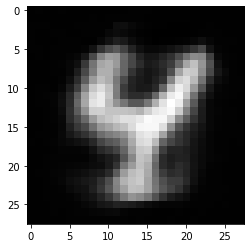

In [147]:
visu_reco(2,6)

In [155]:
def ping_pong(alter,idx,it=1):
    data=source[alter,idx].to(DEVICE)
    print('True label : ',int(label[idx].item()))
    for _ in range(it):
        code = model(data)
        print(code.argmax().item())
        data = model.decoder(code)
    return code 


def flip_tick(alter,idx,it=10):
    
    data=source[alter,idx].to(DEVICE)
    pred = 0 
    first = True
    for k in range(it):
        code = model(data)
        prevPred = pred 
        pred = (code.argmax().item())
        data = model.decoder(code)
        if pred != prevPred and not first:
            return k 
        first = False 
    return -1 

True label :  4
4
8
8
8
8


3

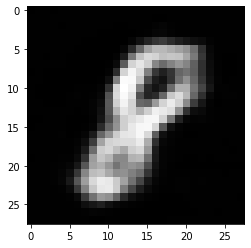

In [163]:
code = ping_pong(3,6,it=5)
print28x28tensor(model.decoder(code.to(DEVICE)).detach())
flip_tick(0,7)

Predicted Label :  4


tensor([-1.6200, -3.7496, -1.4602, -2.9195,  3.3988, -2.2427, -4.3775, -1.2258,
        -1.5876,  2.8413], device='cuda:0', grad_fn=<SqueezeBackward3>)

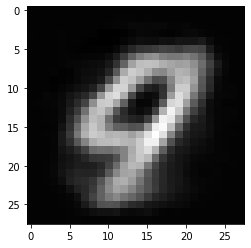

In [150]:
visu_reco(3,4)

# One shot reconstruction loss 

In [151]:
def rec_loss(alter,number):
    idxs = (label==number)
    codes = model(source[alter,idxs].to(DEVICE))
    decodeds = model.decoder(codes)
    losses = torch.zeros(codes.shape[0])
    for i in range(len(losses)):
        losses[i]=loss_reconst(decodeds[i],source[alter,idxs][i].to(DEVICE))
    return losses.mean().item(),losses.std().item()




In [174]:
import plotly.express as px
import pandas as pd 


df= pd.DataFrame({})
for conf in [(0,'Normal'),(1,'FGM'),(2,'FGM Noise'),(3,'CW'),(4,'CW Noise')][1:3]:
    lossMean=[]
    lossStd=[]
    for number in range(10):
        m,s = rec_loss(conf[0],number)
        lossMean.append(m)
        lossStd.append(s)
    dfConf = pd.DataFrame({'number' : list(range(10)),'mean' : lossMean,'std' : lossStd, 'alter' : 10*[conf[1]] })
    df=pd.concat([df,dfConf])
    
fig = px.scatter(df, x="number", y="mean", color="alter", error_y="std")
fig.show()

In [173]:
losses = []
for idx in range(100):
    losses.append(loss_reconst(source[0][idx],source[3][idx]))
losses = np.array(losses)
losses.max()

0.009090663

# First divergence time

In [156]:
flips = torch.zeros(source.shape[:2])
for alter in range(flips.shape[0]):
    for idx in range(flips.shape[1]):
        flips[alter,idx]=flip_tick(alter,idx,it=10)

In [158]:
print('Total number of samples',len(flips[0]))
print('Number of no flips inputs')
for alter in range(5):
    print(alter, ' : ', (flips[alter]==-1).sum().item())

print('Average flip when there is one')
for alter in range(5):
    print(alter, ' : ', flips[alter][flips[alter]!=-1].mean().item())

Total number of samples 160
Number of no flips inputs
0  :  49
1  :  59
2  :  49
3  :  2
4  :  49
Average flip when there is one
0  :  4.549549579620361
1  :  3.584158420562744
2  :  4.360360145568848
3  :  1.1455695629119873
4  :  4.477477550506592


## Visualization of backward network 

In [131]:
#Effective low network visualisation

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 


def mode_transform(weights,sigmaThreshold=3):
    S = []
    V = []
    U = []
    K = []
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(arch)-2)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E2=torch.abs(adjacency[k])
        for i in range(E2.shape[0]):
            for j in range(E2.shape[1]):
                Emin = sigmaThreshold*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":1},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)




    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        mode='markers',
        showlegend=False,
        marker=go.scatter.Marker(
            opacity=1,
        ))

    fig.add_trace(node_trace)

    fig.show()
    return U,S,V


In [132]:
attached_weights = list(model.back_linears.parameters())
detached_weights = [w.detach() for w in attached_weights]
U,S,V=mode_transform(detached_weights)

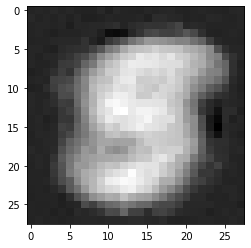

In [107]:
print28x28tensor(U[-1][:,0])

# Attacks on double model 

In [137]:
class DoubleReflexiveModel(nn.Module):
    def __init__(self, model):
        super(DoubleReflexiveModel, self).__init__()
        assert(isinstance(model,ReflexiveModel))
        self.model = model 
        
    def forward(self, x):
        x = self.model(x)
        x = self.model.decoder(x)
        x = self.model(x)
        return x

double_model = DoubleReflexiveModel(model)

In [140]:
n_batch

5

In [138]:
source=attack(double_model)

  1%|▌                                        | 4/313 [06:33<8:26:59, 98.44s/it]


In [161]:
print(6*'-',"Accuracy of double model under different attacks ",6*'-')
for alter,name in enumerate(['Normal', 'FGM', 'FGM Noise', 'CW' , 'CW Noise','DeepFool','DeepFool Noise']):
    print(name, ' : ',(label.to(DEVICE)==double_model(source[alter].to(DEVICE)).argmax(dim=1)).sum().item()/len(label)*100,' %')

------ Accuracy under different attacks  ------
Normal  :  90.0  %
FGM  :  25.0  %
FGM Noise  :  87.5  %
CW  :  0.625  %
CW Noise  :  90.0  %
DeepFool  :  0.0  %
DeepFool Noise  :  90.0  %


# MSE loss along iterations

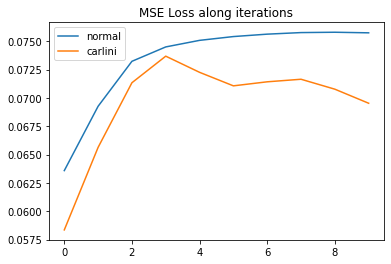

In [193]:
idx = 35
alters=[(0,'normal'),(3,'carlini')]
it = 10
model.eval()
for conf in alters:
    losses = []
    data = source[conf[0],idx].to(DEVICE) 
    output = data
    for _ in range(it):
        code = model(output)
        output = model.decoder(code)
        losses.append(loss_reconst(output,data).item())
    plt.plot(losses,label=conf[1])
plt.legend()
plt.title('MSE Loss along iterations')
plt.show()